In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

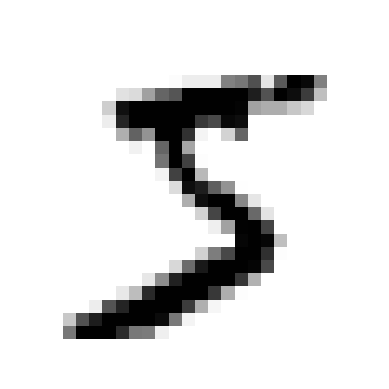

In [21]:
# view a sample image from MNIST
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [14]:
# build the train and test sets from the already split dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
# train a binary classifier to identify digit 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [19]:
# apply stochastic gradient descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd_clf.predict([some_digit])

array([ True])

In [23]:
# evaluate the SGD classifier
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [26]:
# try out a dummy classifier (classifies into the most frequent class)
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [27]:
# evaluate the dummy classifier for comparison
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [29]:
# get out-of-sample predictions
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [31]:
# look at classifier metrics
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


In [32]:
# compute the F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

In [34]:
# compare the decision function with a threshold of 0
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [35]:
# compare the decision function with a threshold of 3000
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

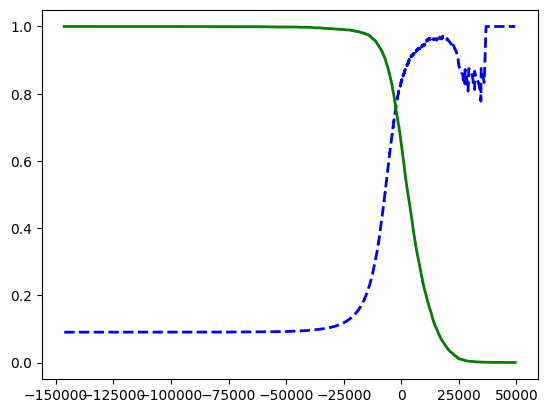

In [36]:
# determine the optimal decision threshold based on cross validation results
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.show()

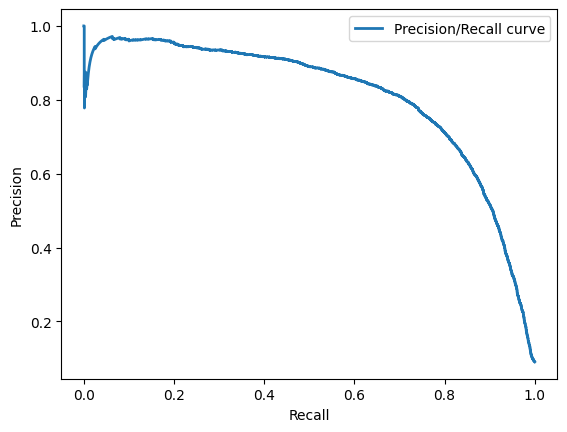

In [50]:
# plot precision against recall
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [38]:
# find the optimal threshold for the desired precision
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439594)

In [39]:
# obtain the classifier's predictions for 90% precision
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(f'precision: {precision_score(y_train_5, y_train_pred_90)}')
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
print(f'recall: {recall_at_90_precision}')

precision: 0.9000345901072293
recall: 0.4799852425751706


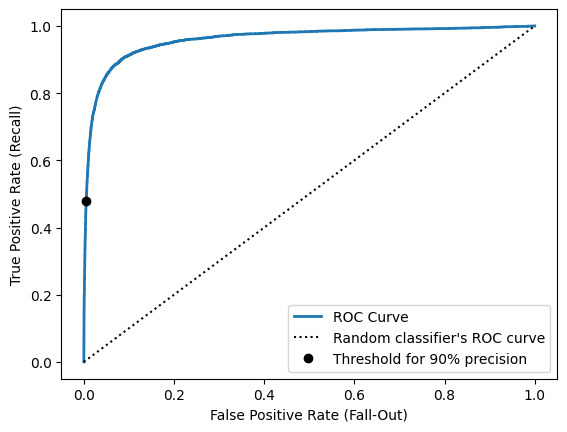

In [49]:
# plot ROC curves for 90% precision
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k:', label='Random classifier\'s ROC curve')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()

In [52]:
# compute the area under the curve (AUC) to gauge classifier performances
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)
# NOTE: use PR curve when false positives are more important than false negatives, otherwise use ROC curve

np.float64(0.9604938554008616)

In [53]:
# compare the  PR curve and F1 of a random forrest classifier to those of the SGDClassifier; remember that random forest doesn't have a decision_function() method but has a predict_proba() method we can use
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

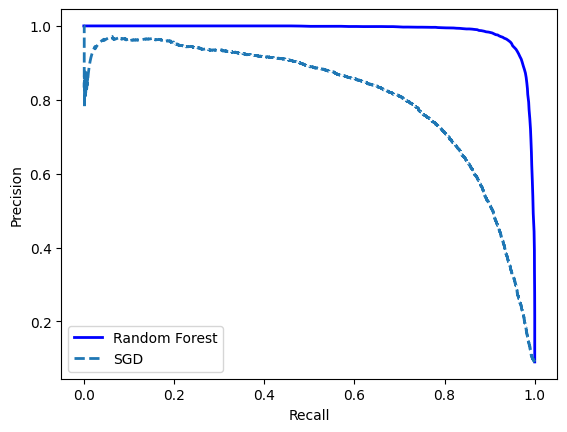

In [54]:
# plot the PR curve for the 2 classifiers
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [57]:
# show the random forest classifier's performance scores
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f'Precision: {precision_score(y_train_5, y_train_pred_forest)}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_forest)}')
print(f'F1: {f1_score(y_train_5, y_train_pred_forest)}')
print(f'ROC_AUC: {roc_auc_score(y_train_5, y_scores_forest)}')

Precision: 0.9897468089558485
Recall: 0.8725327430363402
F1: 0.9274509803921569
ROC_AUC: 0.9983436731328145


In [58]:
# use SVC for multiclass classification
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [60]:
# classify using SVC
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [61]:
# view the results of the decision_function()
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [63]:
# view the class of the highest decision score
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

In [64]:
# look up the winning class id from the list of target classes
svm_clf.classes_[class_id]

'5'

In [65]:
# force SVC to use an OvR classifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [66]:
# make predictions with the OvR classifier
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [67]:
# confirm the number of trained classifiers
len(ovr_clf.estimators_)

10

In [70]:
# use SGD with multiclass classification
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [71]:
# check to see the results of the decision_function()
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [ ]:
# check the overall accuracy of SGD, given the unexpected prediction
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# scale the data and see if the accuracy improves
